## Code for spike sorting

we first need to find the recording experiment directory, then we can load and concatenate the recordings yousin spike interface or find binary files from different experiment in one dey and merge them together then loade them into 

In [1]:
import os
import spikeinterface.full as si
print(f"SpikeInterface version: {si.__version__}")
import spikeinterface.core as sic
import spikeinterface.curation as sc
import spikeinterface.widgets as sw

import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")

# %matplotlib widget
%matplotlib inline

SpikeInterface version: 0.102.2


In [2]:
job_kwargs = dict(n_jobs=20, chunk_duration='3s', progress_bar=True) ## change the number of jobs based on your cpu cores and chunk duration based on your RAM
si.set_global_job_kwargs(**job_kwargs)

In [4]:

base_folder  = r'D:\ephys\R004-DB36D\2025-02-28\mag\2025-02-28_10-24-24'

def get_subfolders(directory):
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir()]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and any(char in f.name for char in 'out')]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and all(char not in f.name for char in 'out')]
    # subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and f.name[-2:].isdigit()]

    subfolders = [f.path for f in os.scandir(directory) if f.is_dir() and f.name[0].isdigit()]

    return subfolders


rec_subfolders = get_subfolders(base_folder)
print(rec_subfolders)

[]


In [4]:
base_folder

'D:\\ephys\\R005-DC221\\2025-02-20'

In [5]:
## when read the binary file, should give the exact number of channels that have been recorded.
## read_openephys discard on extra synch channel
#full_raw_rec = si.read_binary(output_file, 30000, 'int16', num_channels=385, t_starts=None, channel_ids=None, time_axis=0, file_offset=0, gain_to_uV=None, offset_to_uV=None, is_filtered=None, num_chan=None)

In [6]:
recordings_list = []
for dir in rec_subfolders:
    recordings_list.append( si.read_openephys(dir,stream_id='1'))
 
recordings_list

[OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 20,516,034 samples 
                                    683.87s (11.40 minutes) - int16 dtype - 14.67 GiB,
 OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 20,402,170 samples 
                                    680.07s (11.33 minutes) - int16 dtype - 14.59 GiB,
 OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 10,585,836 samples 
                                    352.86s (5.88 minutes) - int16 dtype - 7.57 GiB,
 OpenEphysBinaryRecordingExtractor: 384 channels - 30.0kHz - 1 segments - 16,225,149 samples 
                                    540.84s (9.01 minutes) - int16 dtype - 11.61 GiB]

In [7]:
# Case 2: the sorter (like Kilosort) DOES NOT handle multi-segment objects
# The `concatenate_recordings()` mimics a mono-segment object that concatenates all segments
multirecording = si.concatenate_recordings(recordings_list)
# multirecording = si.append_recordings(recordings_list)

single_rec = si.read_openephys(dir,stream_id='1')
multirecording

ConcatenateSegmentRecording: 384 channels - 30.0kHz - 1 segments - 67,729,189 samples 
                             2,257.64s (37.63 minutes) - int16 dtype - 48.44 GiB

In [8]:
fs = multirecording.get_sampling_frequency()
trace_snippet = multirecording.get_traces(start_frame=int(fs*0), end_frame=int(fs*2))

In [9]:
# let's set a probe
# multirecording = multirecording.set_probe(single_rec.get_probe())
# we automaticaly have the probe loaded!
probe_df = multirecording.get_probe().to_dataframe()

# Save to a CSV file 
probe_df.to_csv(base_folder +'/probe_df.csv', index=False)
probe_df


,x,y,contact_shapes,width,shank_ids,contact_ids
0,250.0,2160.0,square,12.0,1,s1e288
1,282.0,2160.0,square,12.0,1,s1e289
2,250.0,2175.0,square,12.0,1,s1e290
3,282.0,2175.0,square,12.0,1,s1e291
4,250.0,2190.0,square,12.0,1,s1e292
...,...,...,...,...,...,...
379,282.0,1395.0,square,12.0,1,s1e187
380,250.0,1410.0,square,12.0,1,s1e188
381,282.0,1410.0,square,12.0,1,s1e189
382,250.0,1425.0,square,12.0,1,s1e190


(-100.0, 1000.0)

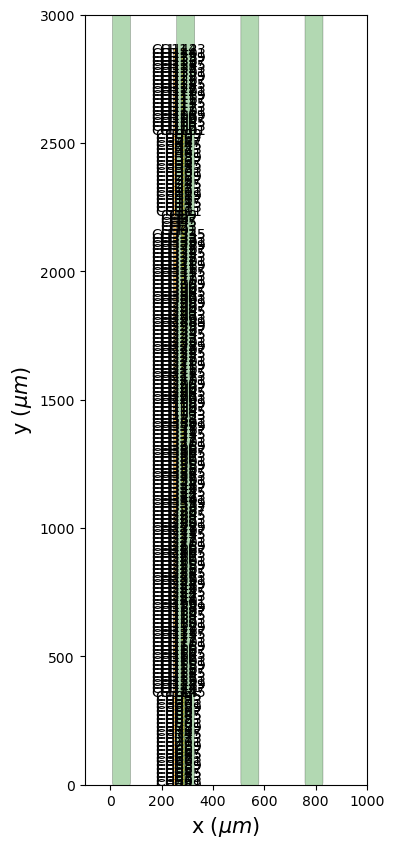

In [10]:
fig, ax = plt.subplots(figsize=(5, 10))
si.plot_probe_map(multirecording, ax=ax, with_channel_ids=True)
ax.set_ylim(00, 3000)
ax.set_xlim(-100, 1000)

## Preprocess the recording


In [11]:

rec1 = si.highpass_filter(multirecording, freq_min=400.)
# rec1 = si.bandpass_filter(
#     multirecording,
#     freq_min=400,
#     freq_max=14900,

#     margin_ms=1500.,
#     filter_order=3,
#     dtype="float32",
#     add_reflect_padding=True,
# )
bad_channel_ids, channel_labels = si.detect_bad_channels(rec1)

print('bad_channel_ids', bad_channel_ids)

bad_channel_ids []


In [12]:
len(bad_channel_ids)

0

In [13]:
rec2 = rec1.remove_channels(bad_channel_ids)
# rec2 = rec2.split_by("group") # if recording are done on several shanks

rec3 = si.phase_shift(rec2)
rec4 = si.common_reference(rec3, operator="median", reference="global")
rec4

CommonReferenceRecording: 384 channels - 30.0kHz - 1 segments - 67,729,189 samples 
                          2,257.64s (37.63 minutes) - int16 dtype - 48.44 GiB

In [14]:

rec = rec4.save(folder=base_folder + '/preprocess', format='binary', **job_kwargs)
# our recording now points to the new binary folder
# rec=si.load_extractor(base_folder + '/preprocess')

rec

write_binary_recording 
engine=process - n_jobs=20 - samples_per_chunk=90,000 - chunk_memory=65.92 MiB - total_memory=1.29 GiB - chunk_duration=3.00s


write_binary_recording (workers: 20 processes):   0%|          | 0/753 [00:00<?, ?it/s]

BinaryFolderRecording: 384 channels - 30.0kHz - 1 segments - 67,729,189 samples 
                       2,257.64s (37.63 minutes) - int16 dtype - 48.44 GiB

## Visualize the preprocessing steps
Interactive explore the preprocess steps could de done with this with the ipywydgets interactive ploter

In [15]:
%matplotlib widget
si.plot_traces({'raw':rec2 ,'cmr': rec4}, backend='ipywidgets',order_channel_by_depth=True)#,time_range=(1426.0,1426.1))

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

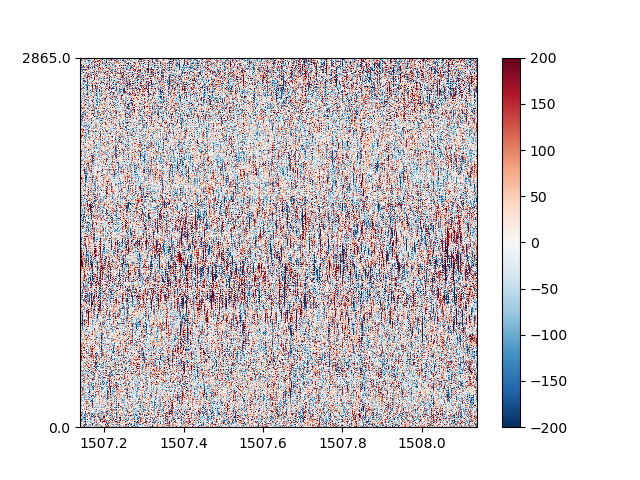

In [16]:
# plot some channels
#fig, ax = plt.subplots(figsize=(8, 10))
some_channels = [ 50, 100,150,200,250,300]
some_chans = rec.channel_ids[some_channels]
# si.plot_traces({'filter':rec3, 'cmr': rec}, backend='matplotlib', mode='line', ax=ax, channel_ids=some_chans)
# si.plot_traces({'cmr': rec}, backend='matplotlib', mode='line', ax=ax, time_range=(1426.0,1426.1))
# plt.savefig("traces.pdf", format="pdf", bbox_inches="tight")
si.plot_traces(rec4,mode= 'map', backend='matplotlib',order_channel_by_depth=True, time_range=(1507.1388,1508.1388))
plt.savefig(base_folder + "/cmr2.pdf", format="pdf")


### Check noise level
A good practice before running a spike sorter is to checd noise  the presenc of driftt16) traces.

In [17]:

# we can estimate the noise on the scaled traces (microV) or on the raw one (which is in our case int16).
noise_levels_microV = si.get_noise_levels(rec4, return_scaled=True)
noise_levels_int16 = si.get_noise_levels(rec4, return_scaled=False)

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

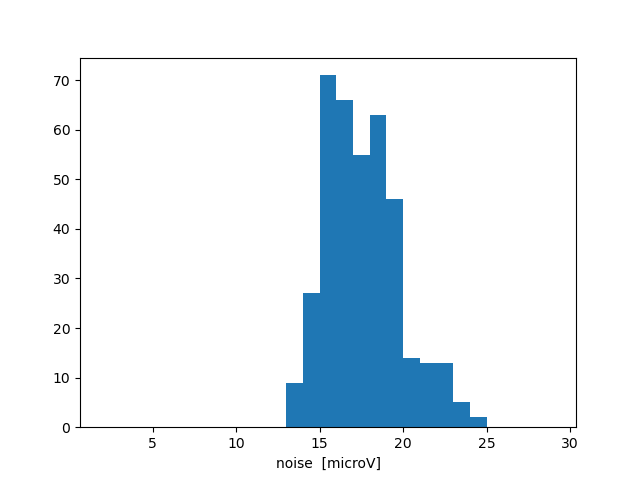

In [18]:
fig, ax = plt.subplots()
_ = ax.hist(noise_levels_microV, bins=np.arange(2, 30,1))
ax.set_xlabel('noise  [microV]')
plt.savefig(base_folder + "/noise_levels_microV.pdf", format="pdf")



## check drift before spike sorting
#### The following will take lots of time

In [19]:
from spikeinterface.sortingcomponents.peak_detection import detect_peaks
from spikeinterface.sortingcomponents.peak_localization import localize_peaks

peaks = detect_peaks(rec4,  method='locally_exclusive', noise_levels=noise_levels_int16,
                     detect_threshold=5, radius_um=50., **job_kwargs)
# peaks
peak_locations = localize_peaks(rec4, peaks, method='center_of_mass', radius_um=50., **job_kwargs)

detect peaks using locally_exclusive (workers: 20 processes):   0%|          | 0/753 [00:00<?, ?it/s]

localize peaks using center_of_mass (workers: 20 processes):   0%|          | 0/753 [00:00<?, ?it/s]

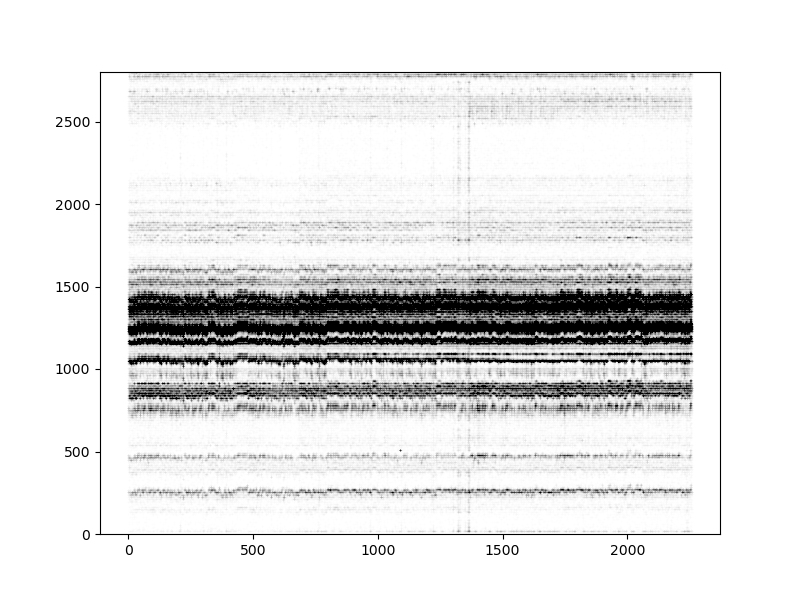

In [21]:
# check for drifts
fs = rec4.sampling_frequency
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(peaks['sample_index'] / fs, peak_locations['y'],s=2, color='k', marker='.',  alpha=0.002)
plt.ylim([0,2800])
plt.savefig(base_folder + "/drift.pdf", format="pdf")


In [36]:
# #we can also use the peak location estimates to have an insight of cluster separation before sorting
# fig, (ax ,ax2) = plt.subplots(1,2,figsize=(10, 20))
# si.plot_probe_map(rec4, ax=ax, with_channel_ids=True)
# ax.set_ylim(-0, 1050)
# ax.set_xlim(-50, 150)
# ax.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)


# si.plot_probe_map(rec4, ax=ax2, with_channel_ids=True)
# ax2.set_ylim(1050, 2100)
# ax2.set_xlim(200, 350)
# ax2.scatter(peak_locations['x'], peak_locations['y'], color='purple', alpha=0.002)

## Run a spike sorter

Important notes:

most of sorters are wrapped from external tools (kilosort, kisolort2.5, spykingcircus, montainsort4 …) that often also need other requirements (e.g., MATLAB, CUDA)

some sorters are internally developed (spyekingcircus2)

external sorter can be run inside a container (docker, singularity) WITHOUT pre-installation

In [37]:
# si.Kilosort2Sorter.set_kilosort2_path('E:\\mathwork\\analysis\\Kilosort-2.0.2')
# si.Kilosort3Sorter.set_kilosort3_path('E:\\mathwork\\analysis\\Kilosort-3.0.2')
# # check the installed Sorter list,

# from spikeinterface.sorters import installed_sorters
# installed_sorters()

In [24]:
# check default params for kilosort
si.get_default_sorter_params('kilosort4')

{'fs': 30000,
 'batch_size': 60000,
 'nblocks': 1,
 'Th_universal': 9,
 'Th_learned': 8,
 'nt': 61,
 'shift': None,
 'scale': None,
 'artifact_threshold': inf,
 'nskip': 25,
 'whitening_range': 32,
 'highpass_cutoff': 300,
 'binning_depth': 5,
 'sig_interp': 20,
 'drift_smoothing': [0.5, 0.5, 0.5],
 'nt0min': None,
 'dmin': None,
 'dminx': 32,
 'min_template_size': 10,
 'template_sizes': 5,
 'nearest_chans': 10,
 'nearest_templates': 100,
 'max_channel_distance': 32,
 'max_peels': 100,
 'templates_from_data': True,
 'n_templates': 6,
 'n_pcs': 6,
 'Th_single_ch': 6,
 'acg_threshold': 0.2,
 'ccg_threshold': 0.25,
 'cluster_downsampling': 20,
 'x_centers': None,
 'duplicate_spike_ms': 0.25,
 'position_limit': 100,
 'do_CAR': True,
 'invert_sign': False,
 'save_extra_vars': False,
 'save_preprocessed_copy': False,
 'torch_device': 'auto',
 'bad_channels': None,
 'clear_cache': False,
 'do_correction': True,
 'skip_kilosort_preprocessing': False,
 'keep_good_only': False,
 'use_binary_file

In [22]:
# params_kilosort= {'batch_size': 5000}
sorting = si.run_sorter('kilosort4', rec, output_folder=base_folder +'/KS4out',
                        docker_image=False,  verbose=True)#,**params_kilosort)

INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Computing preprocessing variables.
INFO:kilosort.run_kilosort:----------------------------------------
INFO:kilosort.run_kilosort:N samples: 67729189
INFO:kilosort.run_kilosort:N seconds: 2257.639633333333
INFO:kilosort.run_kilosort:N batches: 1129
INFO:kilosort.run_kilosort:Preprocessing filters computed in  5.44s; total  5.44s
INFO:kilosort.run_kilosort: 
INFO:kilosort.run_kilosort:Resource usage after preprocessing
INFO:kilosort.run_kilosort:********************************************************
INFO:kilosort.run_kilosort:CPU usage:    26.80 %
INFO:kilosort.run_kilosort:Memory:       10.19 %     |     19.43   /   190.65 GB
INFO:kilosort.run_kilosort:------------------------------------------------------
INFO:kilosort.run_kilosort:GPU usage:    `conda install pynvml` for GPU usage
INFO:kilosort.run_kilosort:GPU memory:   23.15 %     |      2.78   /    11.99 GB
INFO:kilosort.run_kilosort:Allocated:     0.07 %     |      0.01   

kilosort4 run time 3317.61s


In [23]:
## the results can be read back for futur session
# # sorting = si.read_sorter_folder(base_folder + '/KS4out')
base_folder

'D:\\ephys\\R005-DC221\\2025-02-20'

# Post processing 

In [24]:
sorting2 = si.remove_excess_spikes(sorting, rec)

spike_vector = sorting.to_spike_vector()
spike_times_samples = spike_vector['sample_index']
print(spike_times_samples[:10]) # first x spike times

# remove duplicated spikes from the BaseSorting object
sorting2 = sc.remove_duplicated_spikes(sorting2, censored_period_ms=0.1)
sorting2


[  2   4  14  51  86  95 105 106 111 114]


RemoveDuplicatedSpikesSorting: 344 units - 1 segments - 30.0kHz

#### create sorting analyzer and remove duplicated units

In [25]:
analyzer = si.create_sorting_analyzer(sorting2, rec, sparse=True, format="memory")
analyzer

estimate_sparsity (workers: 20 processes):   0%|          | 0/753 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 344 units - 1 segments - memory - sparse - has recording
Loaded 0 extensions

In [26]:
# analyzer.compute("random_spikes", method="uniform", max_spikes_per_unit=500)
# analyzer.compute("waveforms",  ms_before=1,ms_after=2, **job_kwargs)
# analyzer.compute("templates", operators=["average", "median", "std"])
# analyzer.compute("noise_levels")
# analyzer.compute("correlograms")
# analyzer.compute("spike_amplitudes", **job_kwargs)
# analyzer.compute("quality_metrics",**job_kwargs )
analyzer.compute(['noise_levels','random_spikes','waveforms','templates','spike_locations','spike_amplitudes','correlograms','principal_components','quality_metrics','template_metrics'],**job_kwargs)
analyzer.compute('template_metrics', include_multi_channel_metrics=True,**job_kwargs)
analyzer.compute("unit_locations")
analyzer.compute("template_similarity")
# analyzer.compute('principal_components', n_components = 5, mode="by_channel_local")


analyzer


noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

compute_waveforms (workers: 20 processes):   0%|          | 0/753 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/344 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/344 [00:00<?, ?it/s]

Compute : spike_locations + spike_amplitudes (workers: 20 processes):   0%|          | 0/753 [00:00<?, ?it/s]

noise_level (workers: 20 processes):   0%|          | 0/20 [00:00<?, ?it/s]

calculate_pc_metrics:   0%|          | 0/344 [00:00<?, ?it/s]

SortingAnalyzer: 384 channels - 344 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, quality_metrics, unit_locations, template_similarity

In [27]:
# Remove redundant units from the Sorting Analyzer object
# Note this returns a cleaned sorting
clean_sorting = sc.remove_redundant_units(
    analyzer,
    duplicate_threshold=0.95,
    remove_strategy="minimum_shift"
)
# To have a SortingAnalyzer with only the non-redundant units, one must
# select the designed units, remembering to give the format and folder if one wants
# a persistent SortingAnalyzer.
analyzer = analyzer.select_units(clean_sorting.unit_ids)
analyzer

SortingAnalyzer: 384 channels - 336 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, unit_locations, template_similarity, quality_metrics

In [28]:
analyzer_saved = analyzer.save_as(folder=base_folder + "/analyzer", format="binary_folder")
analyzer_saved


# analyzer = si.load_sorting_analyzer(folder=base_folder +"/analyzer") # start from a sorting_analyzer
# analyzer

SortingAnalyzer: 384 channels - 336 units - 1 segments - binary_folder - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, unit_locations, template_similarity, quality_metrics

## Apply AI Model to label clusters

In [29]:
# Apply the noise/not-noise model
noise_neuron_labels = sc.auto_label_units(
    sorting_analyzer=analyzer,
    repo_id="SpikeInterface/UnitRefine_noise_neural_classifier",
    trust_model=True,
)


noise_units = noise_neuron_labels[noise_neuron_labels['prediction']=='noise']
analyzer_neural = analyzer.remove_units(noise_units.index)

# Apply the sua/mua model
sua_mua_labels = sc.auto_label_units(
    sorting_analyzer=analyzer_neural,
    repo_id="SpikeInterface/UnitRefine_sua_mua_classifier",
    trust_model=True,
)

AI_labels = pd.concat([sua_mua_labels, noise_units]).sort_index()
AI_labels

,prediction,probability
0,mua,0.962948
2,noise,0.519795
3,noise,0.589022
4,mua,0.638192
5,mua,0.636349
...,...,...
339,mua,0.850886
340,mua,0.784045
341,noise,0.581449
342,mua,0.792319


#### Export the data for phy

In [30]:
df_prob = AI_labels[["probability"]].rename(columns={"probability": "AI_prob"})
df_prob = df_prob.reset_index()

df_prob

,index,AI_prob
0,0,0.962948
1,2,0.519795
2,3,0.589022
3,4,0.638192
4,5,0.636349
...,...,...
331,339,0.850886
332,340,0.784045
333,341,0.581449
334,342,0.792319


In [31]:
si.export_to_phy(analyzer, output_folder=base_folder + '/ks4phy', 
                 compute_amplitudes=True, compute_pc_features=False, copy_binary=False,
                 **job_kwargs)

# Save model labels along with the exporter data as a TSV file (phy will open them by default)

AI_labels.index.name ='cluster_id'

# Create a DataFrame for the AI probabilities.
# We extract the 'probability' column and rename it to 'AI_prob'.
df_prob = AI_labels[["probability"]].rename(columns={"probability": "AI_prob"})
df_prob = df_prob.reset_index()
df_prob.to_csv(base_folder + '/ks4phy/cluster_AIprob.tsv', sep="\t", index=False)
# same for the predictions
df_labels = AI_labels[["prediction"]].rename(columns={"prediction": "AI_label"})
df_labels = df_labels.reset_index()
df_labels.to_csv(base_folder + '/ks4phy/cluster_AIlabels.tsv', sep='\t',index=False)


Run:
phy template-gui  D:\ephys\R005-DC221\2025-02-20\ks4phy\params.py


In [32]:
# unit_locations = analyzer.get_extension("unit_locations")
# Ulocations = unit_locations.get_data()
# Ulocations[1:5,]


# Autommated curation

In [33]:
print(si.get_quality_metric_list())
print(si.get_quality_pca_metric_list())

['num_spikes', 'firing_rate', 'presence_ratio', 'snr', 'isi_violation', 'rp_violation', 'sliding_rp_violation', 'amplitude_cutoff', 'amplitude_median', 'amplitude_cv', 'synchrony', 'firing_range', 'drift', 'sd_ratio']
['isolation_distance', 'l_ratio', 'd_prime', 'nearest_neighbor', 'nn_isolation', 'nn_noise_overlap', 'silhouette']


In [34]:

qm_ext = analyzer.get_extension("quality_metrics")
metrics = qm_ext.get_data()
metrics = metrics.join(AI_labels, how='right')
metrics

,num_spikes,firing_rate,presence_ratio,snr,isi_violations_ratio,isi_violations_count,rp_contamination,rp_violations,sliding_rp_violation,amplitude_cutoff,...,drift_mad,sd_ratio,isolation_distance,l_ratio,d_prime,silhouette,nn_hit_rate,nn_miss_rate,prediction,probability
cluster_id,,,,,,,,,,,,,,,,,,,,,
0,3437,1.522386,1.000000,2.705889,15.225522,239.0,1.000000,175.0,NaN,9.995079e-05,...,NaN,5.667937,NaN,NaN,NaN,NaN,NaN,NaN,mua,0.962948
2,736,0.326004,1.000000,7.430142,5.556966,4.0,1.000000,3.0,NaN,3.516060e-04,...,NaN,16.056324,8.504573e+01,6.093624,2.300000,-0.165642,0.693000,0.021115,noise,0.519795
3,36,0.015946,0.216216,54.888241,0.000000,0.0,0.000000,0.0,NaN,NaN,...,NaN,11.875352,7.232810e+13,NaN,4.520932,0.159151,0.250000,0.001352,noise,0.589022
4,803,0.355681,1.000000,5.001263,0.000000,0.0,0.000000,0.0,NaN,2.826024e-02,...,NaN,3.856831,1.215322e+02,1.608323,2.305957,0.059439,0.465000,0.022923,mua,0.638192
5,3231,1.431141,1.000000,5.008112,0.432524,6.0,0.632643,4.0,0.285,2.315272e-02,...,NaN,3.241277,1.509311e+02,0.379738,4.035103,0.309519,0.729500,0.016846,mua,0.636349
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
339,16969,7.516257,1.000000,2.424801,1.181298,452.0,1.000000,265.0,NaN,1.603124e-04,...,0.161276,1.024357,7.537296e+01,0.876366,2.000585,0.022544,0.246500,0.051281,mua,0.850886
340,54472,24.127854,1.000000,3.985165,0.606917,2393.0,1.000000,1476.0,NaN,1.782282e-05,...,0.302857,1.686725,7.153251e+01,1.214675,2.317867,0.042932,0.338500,0.032094,mua,0.784045
341,898,0.397761,1.000000,4.108918,0.000000,0.0,0.000000,0.0,0.325,2.887318e-04,...,NaN,1.027986,1.390863e+02,0.003520,7.323871,0.250563,0.958500,0.001250,noise,0.581449


In [35]:
# %matplotlib widget
# sparsity = si.compute_sparsity(analyzer, method = "radius", radius_um = 30) 
# w = si.plot_unit_templates(analyzer,templates_percentile_shading=None,backend = "ipywidgets")

In [36]:
# si.plot_quality_metrics(analyzer, include_metrics=["amplitude_cutoff", "isi_violations_ratio", "snr"], 
#                         backend="ipywidgets")

In [37]:
# first remove noise detected by the model with high confidence
noise_conf_thresh = 0.8
metrics = metrics.loc[
    ~((AI_labels['prediction'] == 'noise') & (AI_labels['probability'] > noise_conf_thresh))
]


In [38]:
# remove some more with a hard threshold on metrics
isi_viol_thresh = 0.4
amp_cutoff_thresh = 0.2
snr_thresh = 2
our_query = f"amplitude_cutoff < {amp_cutoff_thresh} & isi_violations_ratio < {isi_viol_thresh} & snr > {snr_thresh}"
print(our_query)

amplitude_cutoff < 0.2 & isi_violations_ratio < 0.4 & snr > 2


In [39]:
keep_units = metrics.query(our_query)
keep_unit_ids = keep_units.index.values
# keep_units

In [40]:
sorting_auto = clean_sorting.select_units(keep_unit_ids)
print(f"Number of units before curation: {len(clean_sorting.get_unit_ids())}")
print(f"Number of units after curation: {len(sorting_auto.get_unit_ids())}")

Number of units before curation: 336
Number of units after curation: 151


In [41]:
Auto_curated = analyzer.select_units(keep_unit_ids, folder=base_folder + "/waveforms_curated")
Auto_curated

SortingAnalyzer: 384 channels - 151 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, unit_locations, template_similarity, quality_metrics

In [42]:
# %matplotlib widget
# si.plot_quality_metrics(Auto_curated, include_metrics=["amplitude_cutoff", "isi_violations_ratio", "snr"], 
#                         backend="ipywidgets")

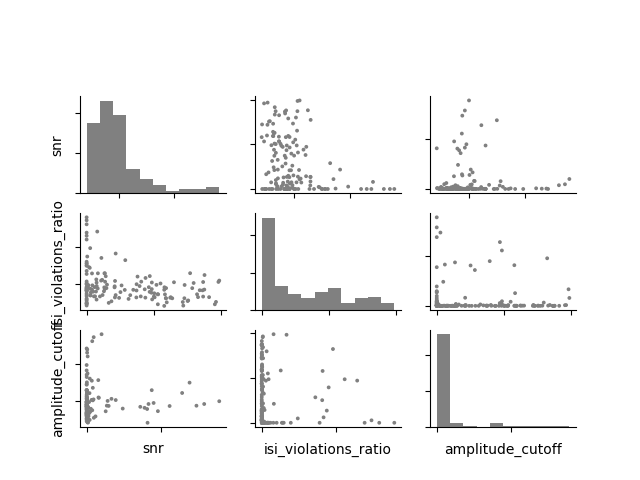

In [43]:
si.plot_quality_metrics(Auto_curated, include_metrics=["amplitude_cutoff", "isi_violations_ratio", "snr"], 
                        backend="matplotlib")

plt.savefig(base_folder + "/qm.pdf", format="pdf")


In [44]:
si.export_to_phy(Auto_curated, output_folder=base_folder + '/ks4phy_autocurated', 
                 compute_amplitudes=True, compute_pc_features=False, copy_binary=False,
                 **job_kwargs)

AI_labels2 = AI_labels.loc[AI_labels.index.isin(keep_unit_ids)]

# Create a DataFrame for the AI probabilities.
# We extract the 'probability' column and rename it to 'AI_prob'.
df_prob = AI_labels2[["probability"]].rename(columns={"probability": "AI_prob"})
df_prob = df_prob.reset_index()
df_prob.to_csv(base_folder + '/ks4phy_autocurated/cluster_AIprob.tsv', sep="\t", index=False)
# same for the predictions
df_labels = AI_labels2[["prediction"]].rename(columns={"prediction": "AI_label"})
df_labels = df_labels.reset_index()
df_labels.to_csv(base_folder + '/ks4phy_autocurated/cluster_AIlabels.tsv', sep='\t',index=False)


Run:
phy template-gui  D:\ephys\R005-DC221\2025-02-20\ks4phy_autocurated\params.py


In [45]:
analyzer

SortingAnalyzer: 384 channels - 336 units - 1 segments - memory - sparse - has recording
Loaded 12 extensions: noise_levels, random_spikes, waveforms, templates, correlograms, principal_components, template_metrics, spike_locations, spike_amplitudes, unit_locations, template_similarity, quality_metrics

In [46]:
df_labels

,cluster_id,AI_label
0,4,mua
1,6,sua
2,10,mua
3,11,sua
4,16,noise
...,...,...
146,334,mua
147,335,mua
148,337,sua
149,338,sua


In [47]:
rec_subfolders

['D:\\ephys\\R005-DC221\\2025-02-20\\2025-02-20_20-58-20',
 'D:\\ephys\\R005-DC221\\2025-02-20\\2025-02-20_21-13-53',
 'D:\\ephys\\R005-DC221\\2025-02-20\\2025-02-20_21-34-20',
 'D:\\ephys\\R005-DC221\\2025-02-20\\2025-02-20_21-43-06']

## save some data regarding the recording

### lets first get the recording date

In [48]:
import os
import datetime

def find_file(directory, filename):
    for root, dirs, files in os.walk(directory):
        if filename in files:
            return os.path.join(root, filename)
    return None

file_name = "settings.xml"
# rec_subfolders[0]
# Find the file
file_path = find_file(rec_subfolders[0], file_name)

if file_path:
    # Get the file creation date
    # creation_time = os.path.getctime(file_path)
    # creation_date = datetime.datetime.fromtimestamp(creation_time).date()
    modification_time = os.path.getmtime(file_path)
    modification_time = datetime.datetime.fromtimestamp(modification_time).date()


    print(f"Recording date: {modification_time}")
else:
    print(f"File '{file_name}' not found in '{rec_subfolder}'")


Recording date: 2025-02-20


#### make a data frame and save it


In [49]:
import pandas as pd

# Example DataFrame
rec_df = pd.DataFrame({
    'rec_date': modification_time,
    'mean_chan_noise': np.mean(noise_levels_microV),
    'chan_locX': [min(probe_df.x)],
    'chan_locY': [min(probe_df.y)]

})

# Save to a CSV file
rec_df.to_csv(base_folder + '/rec_info.csv', index=False)


In [50]:
rec_df

,rec_date,mean_chan_noise,chan_locX,chan_locY
0,2025-02-20,17.579933,250.0,0.0


In [51]:
# unit_locations = analyzer.get_extension("unit_locations")
# Ulocations = unit_locations.get_data()
# Ulocations2 = Ulocations[keep_unit_ids,]
# np.save(base_folder + '/ks4phy_autocurated/unit_locations.npy', Ulocations2)

In [64]:
# np.max(Ulocations2[:,1])